In [61]:
import os
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from torchvision.utils import save_image
from PIL import Image
from collections import Counter
import gc
from tqdm import tqdm
from scipy import linalg
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args


# Monet Style Transfer using GANs



## 1. Description

“Every artist dips his brush in his own soul, and paints his own nature into his pictures.”
-Henry Ward Beecher

We recognize the works of artists through their unique style, such as color choices or brush strokes. The “je ne sais quoi” of artists like Claude Monet can now be imitated with algorithms thanks to generative adversarial networks (GANs). In this project, we will attempt to generate Monet-style images using a GAN.

## 2. Exploratory Data Analysis

We can start by exploring the dataset, which contains images of Monet's paintings and some photos.

The sizes of the Monet images are all the same (256*256):


In [62]:
# Directory paths
monet_path = './gan-data/monet_jpg'
photo_path = './gan-data/photo_jpg'

monet_images = os.listdir(monet_path)
photo_images = os.listdir(photo_path)

In [63]:
def print_image_size_distribution(images_path, image_list):
    size_counter = Counter()

    for img_name in image_list:
        img = Image.open(os.path.join(images_path, img_name))
        size = img.size
        size_counter[size] += 1

    for size, frequency in size_counter.items():
        print(f"Size: {size}, Count: {frequency}")

print_image_size_distribution(monet_path, monet_images)


Size: (256, 256), Count: 300


Below are some example images in Monet paintings and actual photos:

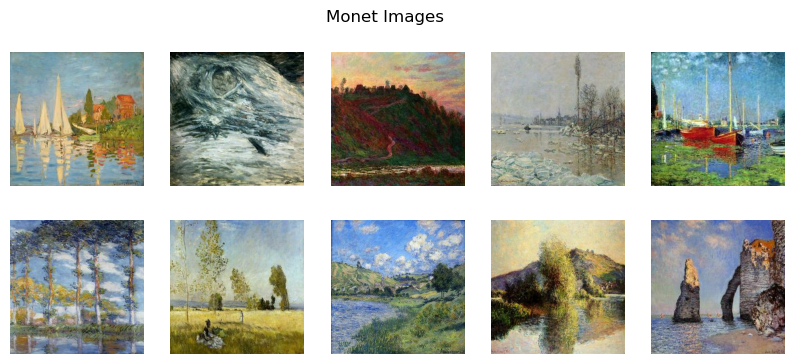

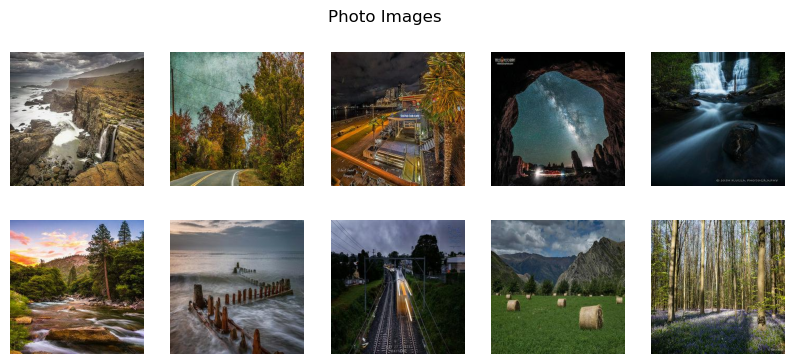

In [64]:
def display_images(images_path, image_list, title, num_images=10):
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        plt.subplot(2, 5, i+1)  # 2 rows, 5 columns
        img = Image.open(os.path.join(images_path, image_list[i]))
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

display_images(monet_path, monet_images, 'Monet Images')
display_images(photo_path, photo_images, 'Photo Images')

The amount of images in each category is as follows:

In [65]:
def count_files_in_directory(directory_path):
    return len([f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))])

# Example usage
monet_file_count = count_files_in_directory('./gan-data/monet_jpg')
photo_file_count = count_files_in_directory('./gan-data/photo_jpg')

print(f"Number of files in Monet directory: {monet_file_count}")
print(f"Number of files in Photo directory: {photo_file_count}")


Number of files in Monet directory: 300
Number of files in Photo directory: 7038


## 3. Model Architecture

### Comparing GAN Architectures

#### CycleGAN vs. StyleGAN: Two Distinct Approaches to Image Generation

**CycleGAN** and **StyleGAN** are both advanced GAN architectures, but they serve different purposes and excel in different areas of image generation and transformation.

#### CycleGAN: Focused on Image-to-Image Translation

- **Use Case**: CycleGAN is specifically designed for tasks that involve translating images from one domain to another, such as converting photographs into Monet-style paintings or vice versa.
- **Key Features**:
  - **Dual Generators and Discriminators**: CycleGAN uses two generators and two discriminators to perform bidirectional image translation between two domains.
  - **Cycle Consistency**: Ensures that if an image is transformed to another domain and then back to its original domain, it closely resembles the original image.
  - **Unpaired Data**: Unlike other models that require paired datasets, CycleGAN can work with unpaired data, making it highly versatile for various translation tasks.

#### StyleGAN: Revolutionizing High-Quality Image Synthesis

- **Use Case**: StyleGAN is primarily used for generating high-resolution, high-quality images from random noise. It is well-known for its ability to generate realistic faces and other complex images.
- **Key Features**:
  - **Style-Based Architecture**: StyleGAN introduces a style-based generator architecture where different levels of the image can be controlled by varying "style" parameters, allowing for fine-grained control over the output.
  - **Progressive Growing**: Images are generated at low resolutions and progressively grown to higher resolutions, enhancing the quality and stability of the output.
  - **High-Quality Image Synthesis**: StyleGAN is particularly effective at creating highly realistic and detailed images, making it ideal for tasks like face generation and artistic creation.

### Conclusion

While both CycleGAN and StyleGAN are powerful tools in the GAN landscape, they cater to different needs. **CycleGAN** excels in image-to-image translation, particularly when working with unpaired data, making it ideal for artistic transformations like converting photos to Monet-style paintings. On the other hand, **StyleGAN** is unmatched in its ability to generate high-quality, detailed images from random noise, making it a go-to choice for creating realistic synthetic images. The choice between the two depends on the specific goals of the project.


### PyTorch Implementation of a Simple GAN

In this section, we define a simple GAN using PyTorch. The GAN consists of a generator and a discriminator, each implemented as a neural network with convolutional layers.

The code first checks for the availability of hardware acceleration (MPS for Apple Silicon, CUDA for NVIDIA GPUs) and sets the computation device accordingly. If neither is available, the computation falls back to the CPU.

In [66]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.instance_norm = nn.InstanceNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.relu(self.instance_norm(self.conv1(x)))
        out = self.instance_norm(self.conv2(out))
        out += residual
        return self.relu(out)


In [67]:
class SimpleGenerator(nn.Module):
    def __init__(self, num_layers=6):
        super(SimpleGenerator, self).__init__()
        self.num_layers = num_layers
        self.initial = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        self.down_sampling = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        )
            
        res_blocks = []
        for _ in range(num_layers):
            res_blocks.append(ResidualBlock(256))
        self.res_blocks = nn.Sequential(*res_blocks)
            
        self.up_sampling = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        self.output = nn.Sequential(
            nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.down_sampling(x)
        x = self.res_blocks(x)
        x = self.up_sampling(x)
        return self.output(x)


In [68]:
class SimpleDiscriminator(nn.Module):
    def __init__(self, num_layers=4):
        super(SimpleDiscriminator, self).__init__()
        self.num_layers = num_layers
        
        layers = [
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        ]

        current_dim = 64
        for _ in range(1, num_layers):
            new_dim = min(current_dim * 2, 512)
            layers += [
                nn.Conv2d(current_dim, new_dim, kernel_size=4, stride=2, padding=1),
                nn.InstanceNorm2d(new_dim),
                nn.LeakyReLU(0.2, inplace=True)
            ]
            current_dim = new_dim

        layers.append(nn.Conv2d(current_dim, 1, kernel_size=4, stride=1, padding=1))
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


### Applying Image Transformations

In this part, we define a series of transformations that can be applied to each image in the dataset. These transformations include resizing the image, randomly flipping it horizontally, rotating it, adjusting its color properties, and more. The class makes it easy to apply these transformations consistently across the entire dataset, enhancing the model’s ability to learn from varied data.


In [69]:
class CustomTransform:
    def __init__(self):
        self.transforms = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def __call__(self, img):
        return self.transforms(img)


### Loading and Preparing Image Data

This section involves handling the loading and preparation of images from a directory. We manage the paths to all image files in the specified directory and apply necessary transformations such as resizing, tensor conversion, and normalization. Then, we focus on creating data loaders for two types of image datasets: Monet-style images and photographs. 


In [70]:
class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = [
            os.path.join(image_dir, img) 
            for img in os.listdir(image_dir) 
            if img.endswith(('jpg', 'png'))
        ]

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            return self.transform(image)
        
        default_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
        return default_transform(image)

    def __len__(self):
        return len(self.image_paths)


In [71]:
def get_data_loaders(monet_dir, photo_dir, batch_size, stage='fit'):
    batch_size = max(1, int(batch_size))

    monet_dataset = CustomImageDataset(monet_dir, transform=CustomTransform())
    monet_loader = DataLoader(monet_dataset, batch_size=batch_size, shuffle=True)

    if stage == "fit":
        photo_dataset = CustomImageDataset(photo_dir, transform=CustomTransform())
    elif stage in ["test", "predict"]:
        photo_dataset = CustomImageDataset(photo_dir)

    photo_loader = DataLoader(photo_dataset, batch_size=batch_size, shuffle=True)
    
    return monet_loader, photo_loader

### Training the GAN Model

This section outlines the process of training that consists of a generator and a discriminator. The training loop involves alternating updates to both networks, aiming to improve the generator's ability to create realistic images and the discriminator's ability to distinguish between real and generated images.


In [72]:
def train(generator, discriminator, monet_loader, photo_loader, num_epochs, device, lr=0.0002):
    criterion = nn.MSELoss()
    optimizer_G = optim.Adam(generator.parameters(), lr, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr, betas=(0.5, 0.999))
    
    for epoch in range(num_epochs):
        for _, (monet_imgs, photo_imgs) in enumerate(zip(monet_loader, photo_loader)):
            real_monet = monet_imgs[0].to(device)
            real_photo = photo_imgs[0].to(device)
            
            optimizer_D.zero_grad()
            fake_monet = generator(real_photo)
            d_loss_real = criterion(discriminator(real_monet), torch.ones_like(discriminator(real_monet)))
            d_loss_fake = criterion(discriminator(fake_monet.detach()), torch.zeros_like(discriminator(fake_monet)))
            d_loss = (d_loss_real + d_loss_fake) / 2
            d_loss.backward()
            optimizer_D.step()
            
            optimizer_G.zero_grad()
            g_loss = criterion(discriminator(fake_monet), torch.ones_like(discriminator(fake_monet)))
            g_loss.backward()
            optimizer_G.step()
            
        print(f"Epoch [{epoch+1}/{num_epochs}], D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")
        
        if (epoch + 1) % 10 == 0:
            torch.save(generator.state_dict(),  os.path.join(output_dir, f'generator_epoch_{epoch+1}.pth'))
            torch.save(generator.state_dict(),  os.path.join(output_dir, f'discriminator_epoch_{epoch+1}.pth'))
    
    return generator, discriminator


## 4. Results and Analysis


### 1. Hyperparameter Tuning

In [73]:
space = [
    Real(0.00001, 0.001, name='learning_rate', prior='log-uniform'),
    Integer(2, 10, name='batch_size'),
    Integer(3, 4, name='generator_layers'),
    Integer(3, 4, name='discriminator_layers')
]


@use_named_args(space)
def objective(**params):
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    generator_layers = params['generator_layers']
    discriminator_layers = params['discriminator_layers']

    generator = SimpleGenerator(num_layers=generator_layers).to(device)
    discriminator = SimpleDiscriminator(num_layers=discriminator_layers).to(device)

    monet_loader, photo_loader = get_data_loaders('./gan-data/monet_jpg/', './gan-data/photo_jpg/', batch_size=batch_size)

    generator, discriminator = train(generator, discriminator, monet_loader, photo_loader, num_epochs=5, device=device, lr=learning_rate)

    score = evaluate_model(generator, discriminator, monet_loader, photo_loader, device)

    return score


def hyperparameter_tuning(device):
    result = gp_minimize(objective, space, n_calls=30, random_state=20, verbose=True)
    
    best_params = {
        'learning_rate': result.x[0],
        'batch_size': result.x[1],
        'generator_layers': result.x[2],
        'discriminator_layers': result.x[3]
    }
    
    return best_params


def evaluate_model(generator, discriminator, monet_loader, photo_loader, device):
    generator.eval()
    discriminator.eval()
    total_loss = 0
    num_batches = 0

    with torch.no_grad():
        for monet_imgs, photo_imgs in zip(monet_loader, photo_loader):
            real_monet = monet_imgs[0].to(device)
            real_photo = photo_imgs[0].to(device)

            fake_monet = generator(real_photo)
            fake_score = discriminator(fake_monet)
            real_score = discriminator(real_monet)

            loss = ((fake_score - 1) ** 2).mean() + ((real_score - 1) ** 2).mean()
            total_loss += loss.item()
            num_batches += 1

    return total_loss / num_batches

In [74]:
output_dir = 'models/'
os.makedirs(output_dir, exist_ok=True)


print("Initiating hyperparameter tuning process...")
best_params = hyperparameter_tuning(device)
print(f"Optimal hyperparameters found: {best_params}")

Initiating hyperparameter tuning process...
Iteration No: 1 started. Evaluating function at random point.
Epoch [1/5], D_loss: 0.1708, G_loss: 0.6712
Epoch [2/5], D_loss: 0.3424, G_loss: 0.9076
Epoch [3/5], D_loss: 0.5665, G_loss: 1.0099
Epoch [4/5], D_loss: 0.2498, G_loss: 0.4521
Epoch [5/5], D_loss: 0.1485, G_loss: 0.4706
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 41.4384
Function value obtained: 0.4362
Current minimum: 0.4362
Iteration No: 2 started. Evaluating function at random point.
Epoch [1/5], D_loss: 0.2609, G_loss: 0.5286
Epoch [2/5], D_loss: 0.2489, G_loss: 0.3934
Epoch [3/5], D_loss: 0.2793, G_loss: 0.3244
Epoch [4/5], D_loss: 0.2536, G_loss: 0.2979
Epoch [5/5], D_loss: 0.3058, G_loss: 0.2982
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 551.6100
Function value obtained: 0.5609
Current minimum: 0.4362
Iteration No: 3 started. Evaluating function at random point.
Epoch [1/5], D_loss: 0.2607, G_loss: 0.3719
Epoch [2/5], D_loss: 

In [92]:

monet_loader, photo_loader = get_data_loaders(monet_path, photo_path, batch_size=best_params['batch_size'])

generator = SimpleGenerator(num_layers=best_params['generator_layers']).to(device)
discriminator = SimpleDiscriminator(num_layers=best_params['discriminator_layers']).to(device)

print("Initiating tuning process with best hyperparameter...")
generator, discriminator = train(generator, discriminator, monet_loader, photo_loader, num_epochs=100, device=device, lr=best_params['learning_rate'])

Initiating tuning process with best hyperparameter...
Epoch [1/100], D_loss: 0.2273, G_loss: 0.5141
Epoch [2/100], D_loss: 0.2079, G_loss: 0.5661
Epoch [3/100], D_loss: 0.1976, G_loss: 0.4488
Epoch [4/100], D_loss: 0.1834, G_loss: 0.5742
Epoch [5/100], D_loss: 0.3343, G_loss: 0.3352
Epoch [6/100], D_loss: 0.3164, G_loss: 0.2818
Epoch [7/100], D_loss: 0.2667, G_loss: 0.4540
Epoch [8/100], D_loss: 0.2165, G_loss: 0.4631
Epoch [9/100], D_loss: 0.2957, G_loss: 0.2484
Epoch [10/100], D_loss: 0.0929, G_loss: 0.7197
Epoch [11/100], D_loss: 0.2961, G_loss: 0.5314
Epoch [12/100], D_loss: 0.4489, G_loss: 0.2003
Epoch [13/100], D_loss: 0.2783, G_loss: 0.3940
Epoch [14/100], D_loss: 0.2687, G_loss: 0.3700
Epoch [15/100], D_loss: 0.2651, G_loss: 0.3762
Epoch [16/100], D_loss: 0.3109, G_loss: 0.4123
Epoch [17/100], D_loss: 0.3296, G_loss: 0.5322
Epoch [18/100], D_loss: 0.2716, G_loss: 0.3018
Epoch [19/100], D_loss: 0.3261, G_loss: 0.2949
Epoch [20/100], D_loss: 0.7083, G_loss: 0.4499
Epoch [21/100],

In [104]:

def generate_and_save_images(generator, photo_loader, num_images, output_dir, device):
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'original'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'generated'), exist_ok=True)

    generator.eval()

    with torch.no_grad():
        image_counter = 0
        for _, batch_images in tqdm(enumerate(photo_loader), total=num_images):
            if image_counter >= num_images:
                break

            batch_images = batch_images.to(device)
            fake_images = generator(batch_images)

            # save each image in the batch individually
            for j in range(batch_images.size(0)):
                if image_counter >= num_images:
                    break

                original_image = batch_images[j]
                generated_image = fake_images[j]

                save_image(original_image, os.path.join(output_dir, 'original', f'original_{image_counter}.jpg'), normalize=True)
                save_image(generated_image, os.path.join(output_dir, 'generated', f'generated_{image_counter}.jpg'), normalize=True)

                image_counter += 1


def arrange_images(output_dir, num_samples=5):
    original_dir = os.path.join(output_dir, 'original')
    generated_dir = os.path.join(output_dir, 'generated')

    original_images = sorted(os.listdir(original_dir))[:num_samples]
    generated_images = sorted(os.listdir(generated_dir))[:num_samples]

    fig, axes = plt.subplots(2, num_samples, figsize=(4*num_samples, 8))
    fig.suptitle("Comparisons of Images", fontsize=18, fontweight='bold')

    # Plot all original images in the first row
    for i in range(num_samples):
        img_orig = plt.imread(os.path.join(original_dir, original_images[i]))
        axes[0, i].imshow(img_orig)
        axes[0, i].set_title(f"Original Img {i+1}")
        axes[0, i].axis('off')
        axes[0, i].set_facecolor('lightgray')

    # Plot all generated images in the second row
    for i in range(num_samples):
        img_gen = plt.imread(os.path.join(generated_dir, generated_images[i]))
        axes[1, i].imshow(img_gen)
        axes[1, i].set_title(f"Generated Img {i+1}")
        axes[1, i].axis('off')
        axes[1, i].set_facecolor('lightgray')

    plt.tight_layout(rect=[0, 0, 1, 0.96], h_pad=2.0)
    plt.savefig(os.path.join(output_dir, 'comparison.png'), bbox_inches='tight')
    plt.show()


### 4. Generate Images

  0%|          | 0/10 [00:00<?, ?it/s]

 40%|████      | 4/10 [00:01<00:02,  2.36it/s]


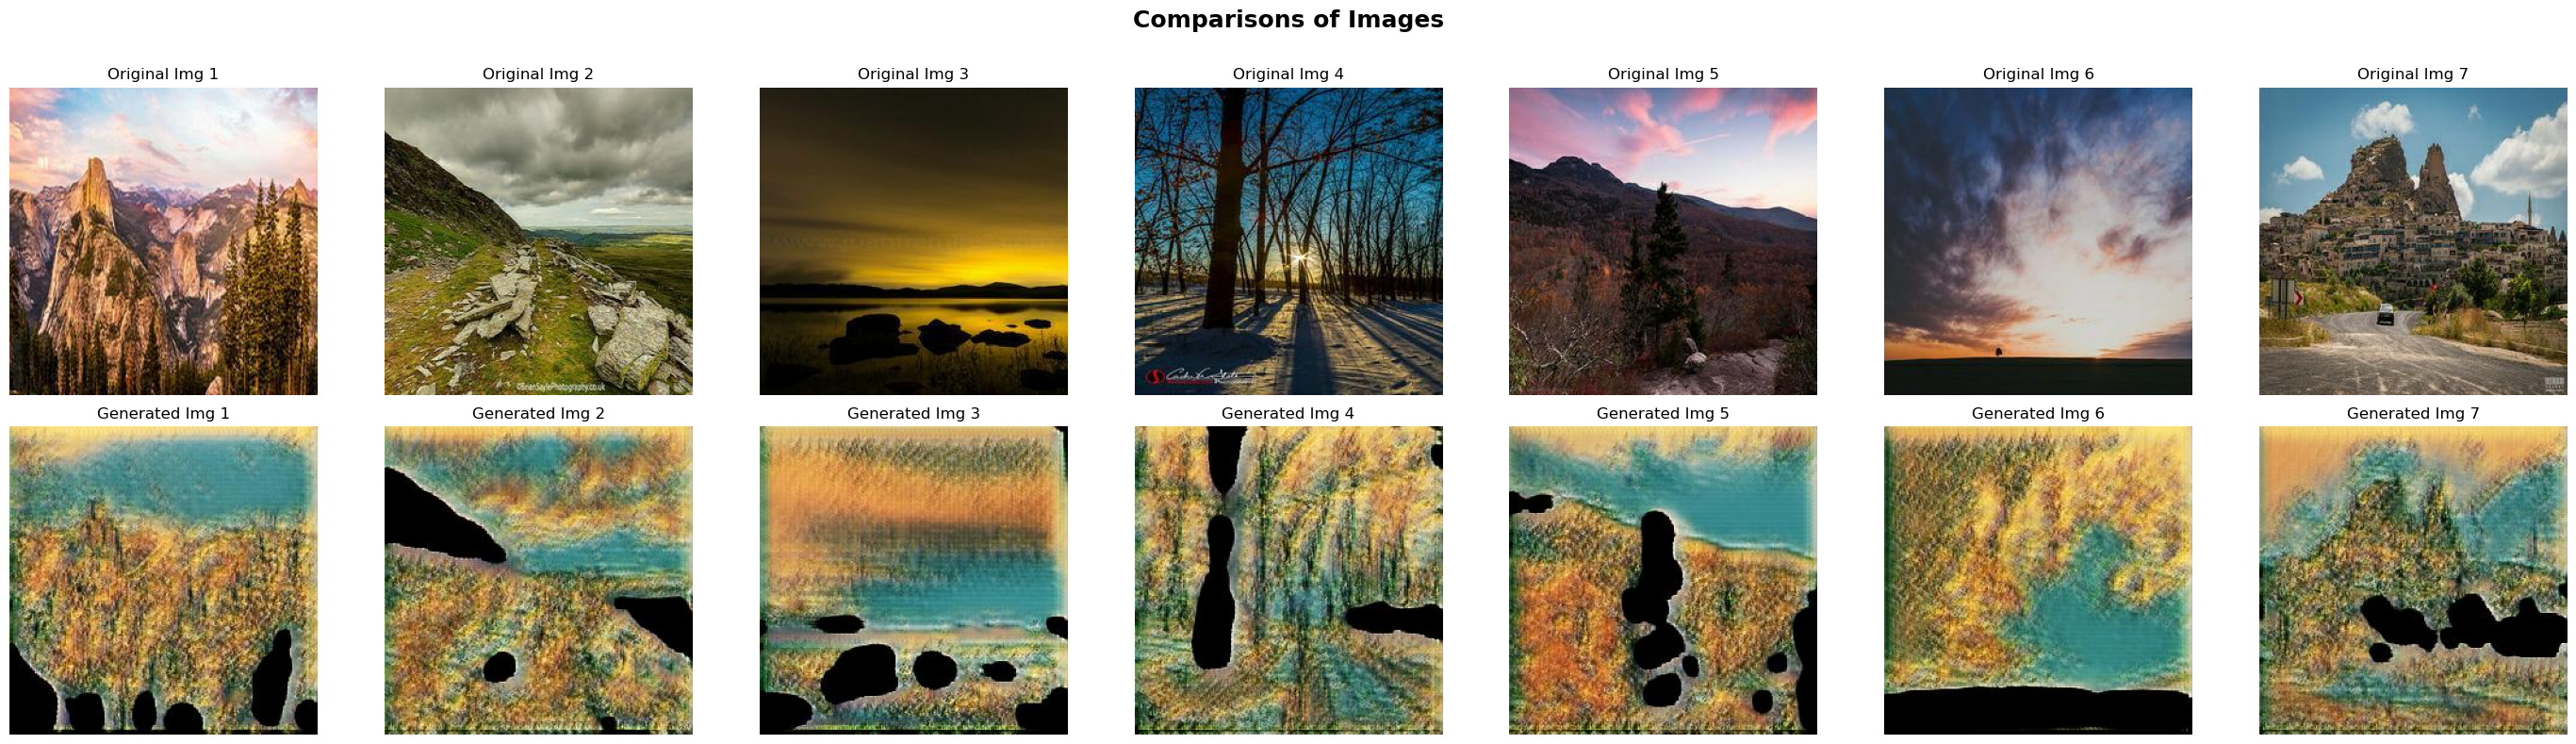

In [107]:
_, photo_loader = get_data_loaders('./gan-data/monet_jpg/', './gan-data/photo_jpg/', batch_size=best_params['batch_size'], stage='test')
generate_and_save_images(generator, photo_loader, num_images=10, output_dir='res', device=device)
arrange_images(output_dir='res', num_samples=7)

In [110]:
import zipfile
import io

def create_image_zip(model, data_loader, total_images, output_zip_path, device):
    model.eval()

    convert_to_pil = transforms.ToPILImage()

    with zipfile.ZipFile(output_zip_path, 'w') as zip_file:
        saved_images_count = 0
        with torch.no_grad():
            for input_batch in tqdm(data_loader, desc="Processing images"):
                input_batch = input_batch.to(device)
                output_images = model(input_batch)

                # Initialize index for while loop
                i = 0
                while i < output_images.size(0) and saved_images_count < total_images:
                    image_tensor = output_images[i].cpu().clamp(-1, 1) * 0.5 + 0.5
                    image_pil = convert_to_pil(image_tensor)
                    image_pil = image_pil.resize((256, 256), Image.LANCZOS)

                    image_bytes = io.BytesIO()
                    image_pil.save(image_bytes, format='JPEG', quality=95)
                    image_bytes = image_bytes.getvalue()

                    zip_file.writestr(f'image_{saved_images_count:05d}.jpg', image_bytes)

                    saved_images_count += 1
                    i += 1

# Example usage
create_image_zip(model=generator, 
                 data_loader=photo_loader, 
                 total_images=100, 
                 output_zip_path='res/processed_images.zip', 
                 device=device)


Processing images: 100%|██████████| 2346/2346 [07:19<00:00,  5.33it/s]


## 5. Conclusion

**Project Overview:**  
In this project, we utilized Generative Adversarial Networks (GANs) to transform photographs into Monet-style paintings. We explored the dataset, designed a simple GAN architecture, and conducted extensive training and hyperparameter tuning to achieve the best results.

**Key Achievements:**
- Successfully implemented a GAN to capture Monet's artistic style.
- Utilized hyperparameter tuning to optimize model performance.
- Generated Monet-style images that effectively mimic the color palette and brushstroke patterns typical of Monet's work.

**Future Enhancement**
- Explore more advanced architectures like CycleGAN for better image-to-image translation.
- Increase training time and dataset size to enhance the quality of generated images.
- Experiment with different loss functions and regularization techniques to stabilize and improve training outcomes.
